# Introduction

[Dataset in Kaggle](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data)

[Paper](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5): Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020). 




# Exploring The Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import math

In [4]:
df = pd.read_csv('../data/heart_failure_clinical_records_dataset.csv')

In [5]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [6]:
df.shape

(299, 13)

In [7]:
df['DEATH_EVENT'].sum() / df.shape[0]

0.3210702341137124

In [8]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [9]:
binary_vars = "anaemia diabetes high_blood_pressure smoking".split()
multival_vars = [var for var in list(df.columns) if var not in binary_vars + ["sex", "DEATH_EVENT"]]
print("Binary variables:", binary_vars)
print("Multi-value variables:", multival_vars)

Binary variables: ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking']
Multi-value variables: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


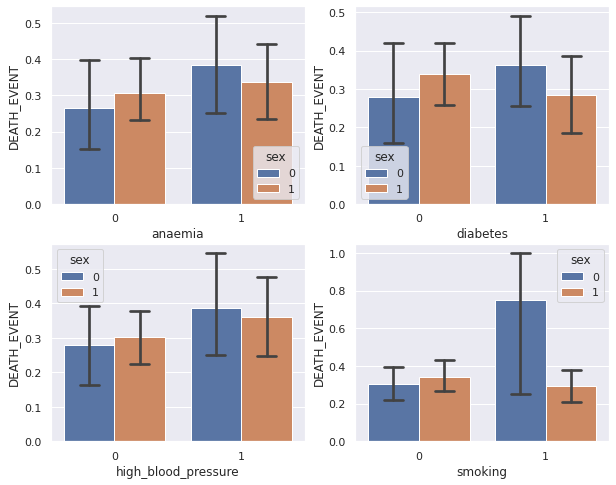

In [10]:
fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(10, 8))
for i in range(2):
    for j in range(2):
        sns.barplot(x=binary_vars[2*i+j], y='DEATH_EVENT', hue='sex', data=df, ax=ax[i, j], capsize=.15)

Perhaps surprisingly, the categorical features: anaemia, diabetes, hypertension and smoking, do not seem to exhibit statistically significant impact on the patient survival prospects. Neither does the sex.
Curiously, the big uncertainty for the smoking women (`sex = 0`) must be reflective of very few patients in this category.

In [11]:
df.query('sex == 0 & smoking == 1')['DEATH_EVENT']

41     1
54     1
76     0
105    1
Name: DEATH_EVENT, dtype: int64

Indeed there were only 4 such women and 3 have passed away, yielding 75% value of the bar height and big uncertainty.

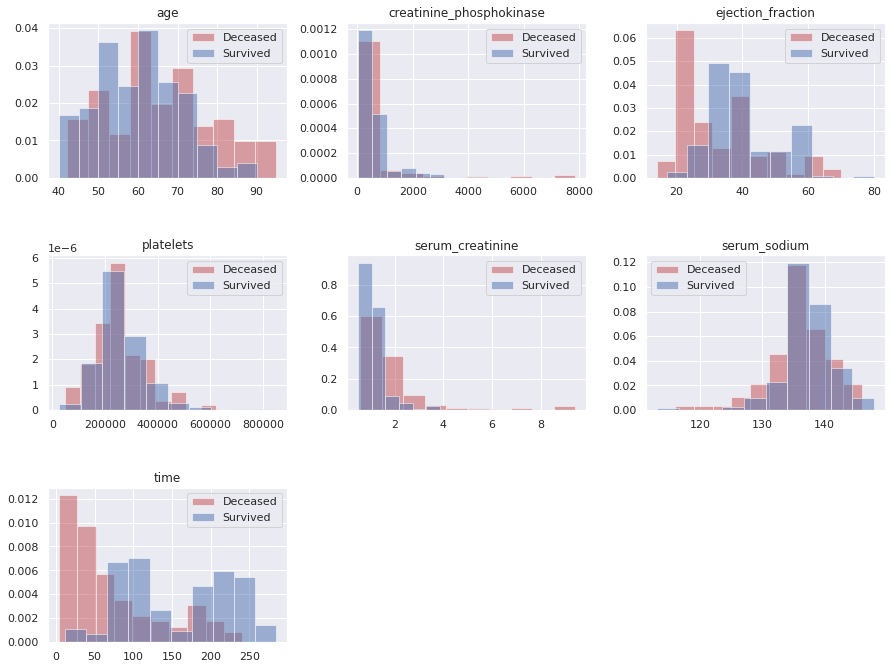

In [19]:
def print_fig(data, cols, ncols=3, figsize=(15,8)):
    """Plot histograms of `cols` superimposing target categories."""
    nrows = math.ceil(len(cols) / ncols)
    f = plt.figure(figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            ind = i * nrows + j
            if ind > len(cols) - 1:
                break
            ax = f.add_subplot(nrows, ncols, ind+1)
            cat1 = data[data["DEATH_EVENT"] == 1]
            cat2 = data[data["DEATH_EVENT"] == 0]
            cat1[cols[ind]].hist(alpha=0.5, ax=ax, color='r', density=True, label='Deceased')
            cat2[cols[ind]].hist(alpha=0.5, ax=ax, color='b', density=True, label='Survived')
            ax.set_title(cols[ind])
            ax.legend(loc='best')
            f.subplots_adjust(hspace=0.5, wspace=0.25, top=1.2)
print_fig(data=df, cols=multival_vars)            

- **age**: patients above the age of 70 are obviously at a higher risk
- **ejection fraction** is a strong predictor, especially below around 30 units
- **serum creatinine** is also a very strong feature, specifically about around 2 units
- **serum sodium** might be a helpful feature, but a little less so than the two previous ones
- **follow-up duration (time)**: We can tell that the patient chance to die in the follow-up period roughly follows an exponential distribution, for those that will not survive, as one might expect. The meaning of the follow-up period for the survivors is less clear: it seems it merely reflects how long these patients were monitored. In any case, this variable can help distinguish the two categories of patients.

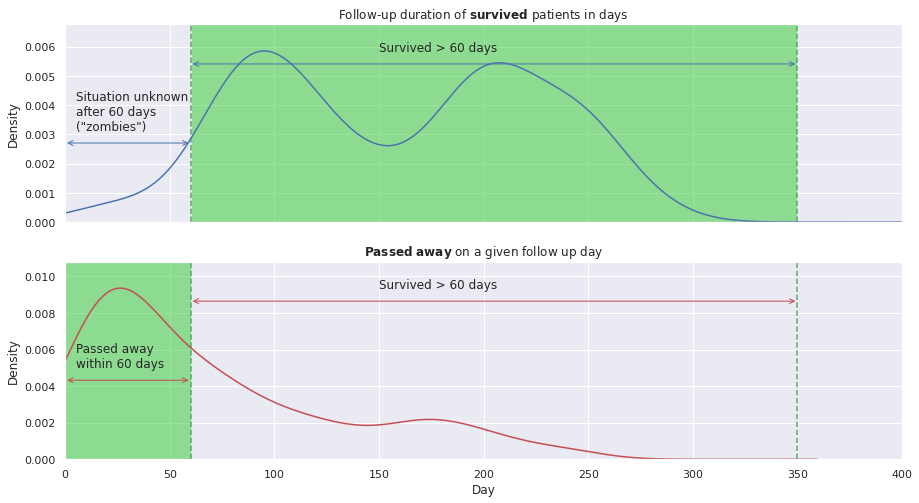

In [55]:
def plot_time(n_days=60):
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,8))
    KERNEL_WIDTH = 0.3 # KDE smoothing parameter
    N_DAYS = n_days

    # Configure what plots display
    from collections import namedtuple
    config = namedtuple('config', ['text1', 'text2', 'title', 'colour', 'hlight'])
    survived_config = config(f'Situation unknown\nafter {N_DAYS} days\n("zombies")',
                             f'Survived > {N_DAYS} days',
                             r'Follow-up duration of $\bf{survived}$ patients in days',
                             'b', (N_DAYS, 350))
    dead_config = config(f'Passed away\nwithin {N_DAYS} days',
                         f'Survived > {N_DAYS} days',
                         r'$\bf{Passed}$ $\bf{away}$ on a given follow up day',
                         'r', (0, N_DAYS))
    configs = (survived_config, dead_config)
    
    # Make the plots
    for i, ax in enumerate(axes):
        df[df['DEATH_EVENT'] == i]['time'].plot.kde(bw_method=KERNEL_WIDTH, ax=ax, color=configs[i].colour)
        ax.set_ylim(0, ax.get_ylim()[1]*1.1)
        ax.set_title(configs[i].title)
        ax.set_xlabel('Day')
        ax.set_xlim(0, 400)
        ax.vlines(x=[0, N_DAYS, 350], ymin=0, ymax=ax.get_ylim()[1], color='g', linestyles='dashed')

        ax.annotate(text=configs[i].text1, xy=(5, 0.45*ax.get_ylim()[1]),
                    xytext=(5, 0.45*ax.get_ylim()[1]), ha='left', va='bottom')#,
                    #bbox=dict(boxstyle="round", alpha=0.1))
        ax.annotate(text='', xy=(0, 0.4*ax.get_ylim()[1]),
                    xytext=(N_DAYS, 0.4*ax.get_ylim()[1]),
                    arrowprops=dict(arrowstyle='<->', color=configs[i].colour))
        
        ax.annotate(text=configs[i].text2, xy=(N_DAYS, 0.85*ax.get_ylim()[1]),
                    xytext=(150, 0.85*ax.get_ylim()[1]), va='bottom')#,
                    #bbox=dict(boxstyle="round", alpha=0.1))
        ax.annotate(text='', xy=(N_DAYS, 0.8*ax.get_ylim()[1]),
                    xytext=(350, 0.8*ax.get_ylim()[1]),
                    arrowprops=dict(arrowstyle='<->', color=configs[i].colour))

        ax.axvspan(*configs[i].hlight, facecolor='limegreen', alpha=0.5)
plot_time()

Interestingly, the 'time' feature has different meaning for either category of patients:
- for **survived** patients: duration of the follow-up time
- for **deceased** patients: day of their passing

Therefore, the former ones might have passed away anytime after the follow-up termination.
For instance, they might have passed away anytime between their follow-up duration and the full 350-day period.
Hence, the patients that are potentially **dead don't die** in the data; they will be hereafter referred to as 'zombies' ;-).

As a break while reading this notebook I recommend the wonderful Sturgill Simpson's ["The Dead Don't Die" song](https://www.youtube.com/watch?v=xiukuoSjDj0) ;-)

Selecting the 'survivors' of follow-up duration greater than $m$ days (`time`$>m$ days) means they have *certainly* survived the first $m$ days.
On the other hand, to be consistent, we must choose the 'non-survivors' who have passed away *within* the first $m$ days (`time`$ < m$ days). The corresponding regions are highlighted in the graphs.

This way we will be able to analyse how likely a given patient is to survive $m$ days, e.g. 2 months, after the heart failure.

The patients whose follow-up duration is smaller than $m$ need to be rejected, reducing our statistics.

Curiously, for the **survivors** (within $m$ days) target label, we might also include the ones who passed away after $m$ days. However, it seems preferable not to do this: I would rather tell a patient they are going to survive at least $m$ days if they *might survive even longer* than that rather than if they are *bound to* pass away anywhere from the day $m+1$ onwards. Both approaches are fine, though.

## General lessons so far
- Feeding features directly to a ML algorithm is a *wrong* practise
- Meaning of target labels might be more subtle than it seems (here 'DEATH_EVENT' relates to another feature, follow-up time);
- Then, one has to disentangle labels and features
- Ignoring some features we do not understand is dangerous, especially if they somehow relate to the labels
- Be patient and use a "pause and think" (or "pause and plot") approach before any classification / regression
- Regarding data collection, the follow-up period should have been the same for each patient (if possible), e.g. 1 year

At this point it is astonishing that the paper authors **ignored** the `time` variable in one of their studies, trying to justify it as follows:
> In the previous part of the analysis, we excluded follow-up
time from the dataset because we prefered to focus on the
clinical features and to try to discover something meaningful about them.

This approach is evidently **biased** as they might have had contaminated train and test samples: people who *might* have died were considered *survivors*.

Let us see how many patients are we left with for various values of $m$.

Max sum arg: 70 days
Max F1 arg: 100 days


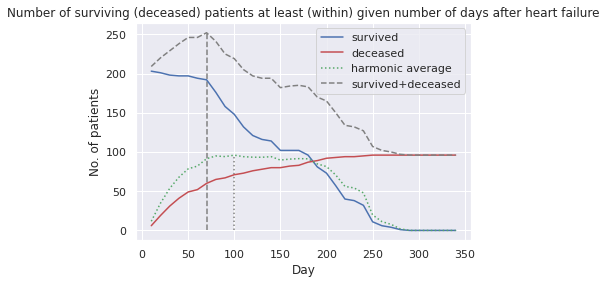

In [56]:
def plot_survived_died_period(n_min=10, n_max=350, step=10):
    days = []
    survived_arr = []
    deceased_arr = []
    f1 = []
    sum_all = []
    for n in range(n_min, n_max, step):
        days.append(n)
        survived = ((df['DEATH_EVENT'] == 0) & (df['time'] > n)).sum()
        survived_fr = survived / (df['DEATH_EVENT'] == 0).sum()
        died = ((df['DEATH_EVENT'] == 1) & (df['time'] < n)).sum()
        died_fr = died / (df['DEATH_EVENT'] == 1).sum()
        survived_arr.append(survived)
        deceased_arr.append(died)
        f1.append(2 * (survived * died) / (survived + died))
        sum_all.append(survived + died)
    max_sum_arg = np.argmax(sum_all)
    max_f1_arg = np.argmax(f1)
    print("Max sum arg:", days[max_sum_arg], "days")
    print("Max F1 arg:", days[max_f1_arg], "days")
    plt.plot(days, survived_arr, label='survived', color='b')
    plt.plot(days, deceased_arr, label='deceased', color='r')
    plt.plot(days, f1, label='harmonic average', color='g', linestyle='dotted')
    plt.plot(days, sum_all, label='survived+deceased', color='gray', linestyle='dashed')
    plt.vlines(x=days[max_sum_arg], ymin=0, ymax=sum_all[max_sum_arg], linestyles='dashed', colors='gray')
    plt.vlines(x=days[max_f1_arg], ymin=0, ymax=f1[max_f1_arg], linestyles='dotted', colors='gray')
    plt.xlabel("Day")
    plt.ylabel("No. of patients")
    plt.title("Number of surviving (deceased) patients at least (within) given number of days after heart failure")
    plt.legend(loc='best')
    plt.show()
plot_survived_died_period()

Maximising harmonic average ensures the two variables are high and close by (i.e. balanced).
The harmonic average has an approximately plateau in the region around 75-175 days.
We might try to run the ML algorithms in that range.

The maximum harmonic average in on the 100-th day and the maximum sum of survived and deceased patients is achieved if we split at the 70-th day. If we want to have both, high statistics and good balance between the categories, we should consider splitting around the 75-100 days. Of course, all other values are technically possible, but they should yield less precise ML performance (which claim we might test).

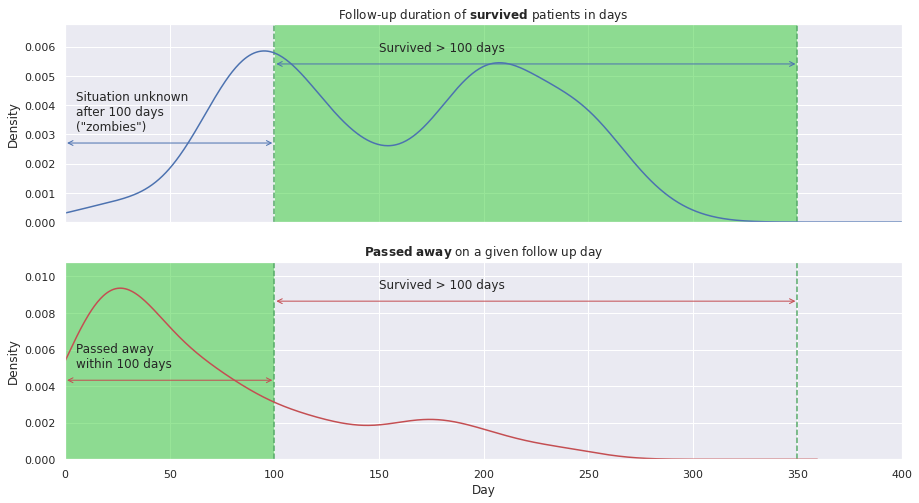

In [57]:
plot_time(100)

# Train set and test set
It is time to split the dataset into train and test sets.
Due to rather small statistics, we need to use stratified sampling to ensure the subgroups (i.e. surviving and deceased patients, and train/test patients) are representative of the population (i.e. the full dataset).

In [703]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.5,
            train_size=None)

In [704]:
# Select the patients
def select_df(n=100):
    select = (((df['DEATH_EVENT'] == 0) & (df['time'] > n)) | ((df['DEATH_EVENT'] == 1) & (df['time'] < n)))
    return df[select]
df = select_df()

# Remove not useful features
df = df.drop(["time"], axis=1)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,1


In [705]:
train_set, test_set = train_test_split(df, test_size=0.4, random_state=42)

In [709]:
X_train = train_set.drop(["DEATH_EVENT"], axis=1) # drop labels and time for training set
y_train = train_set["DEATH_EVENT"].copy()
X_test = test_set.drop(["DEATH_EVENT"], axis=1) # drop labels and time for test set
y_test = test_set["DEATH_EVENT"].copy()

In [710]:
X_train

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
223,47.0,0,582,0,25,0,130000.00,0.8,134,1,0
179,55.0,0,835,0,40,0,279000.00,0.7,140,1,1
200,63.0,1,1767,0,45,0,73000.00,0.7,137,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1
133,63.0,0,193,0,60,1,295000.00,1.3,145,1,1
...,...,...,...,...,...,...,...,...,...,...,...
170,51.0,1,582,1,35,0,263358.03,1.5,136,1,1
15,82.0,1,379,0,50,0,47000.00,1.3,136,1,0
152,50.0,0,115,0,45,1,184000.00,0.9,134,1,1
257,58.0,0,132,1,38,1,253000.00,1.0,139,1,0


In [711]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [713]:
type(X_train)

pandas.core.frame.DataFrame

In [714]:
pipeline = Pipeline([
        #('time_bin', TimeBinning(bin_size=30)),
        ('std_scaler', StandardScaler()),
    ])

X_train_tr = pipeline.fit_transform(X_train)

In [715]:
X_train_tr

array([[-1.13454396, -0.83743579, -0.05671184, ..., -0.62481182,
         0.72336423, -0.6990253 ],
       [-0.46342344, -0.83743579,  0.16941911, ...,  0.75082429,
         0.72336423,  1.4305634 ],
       [ 0.20769707,  1.1941214 ,  1.00243904, ...,  0.06300623,
         0.72336423, -0.6990253 ],
       ...,
       [-0.88287377, -0.83743579, -0.4741156 , ..., -0.62481182,
         0.72336423,  1.4305634 ],
       [-0.21175325, -0.83743579, -0.45892103, ...,  0.5215516 ,
         0.72336423, -0.6990253 ],
       [ 0.20769707,  1.1941214 , -0.05671184, ...,  0.06300623,
         0.72336423,  1.4305634 ]])

In [716]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty='l2', C=1.0, random_state=0,
                             n_jobs=-1)
log_reg.fit(X_train_tr, y_train)

LogisticRegression(n_jobs=-1, random_state=0)

In [717]:
some_data = X_train_tr[:5].copy()
log_reg.predict(some_data)

array([0, 0, 0, 0, 0], dtype=int64)

In [718]:
X_train_tr

array([[-1.13454396, -0.83743579, -0.05671184, ..., -0.62481182,
         0.72336423, -0.6990253 ],
       [-0.46342344, -0.83743579,  0.16941911, ...,  0.75082429,
         0.72336423,  1.4305634 ],
       [ 0.20769707,  1.1941214 ,  1.00243904, ...,  0.06300623,
         0.72336423, -0.6990253 ],
       ...,
       [-0.88287377, -0.83743579, -0.4741156 , ..., -0.62481182,
         0.72336423,  1.4305634 ],
       [-0.21175325, -0.83743579, -0.45892103, ...,  0.5215516 ,
         0.72336423, -0.6990253 ],
       [ 0.20769707,  1.1941214 , -0.05671184, ...,  0.06300623,
         0.72336423,  1.4305634 ]])

In [719]:
#pd.DataFrame(pipeline.inverse_transform(some_data), columns=df.columns[:-1])

In [720]:
y_train[:5]

223    0
179    0
200    0
2      1
133    0
Name: DEATH_EVENT, dtype: int64

In [721]:
# Cross validation
from sklearn.model_selection import cross_val_score

In [722]:
scores = cross_val_score(log_reg, X_train_tr, y_train,
                         scoring="accuracy", cv=5)
print("Scores:", scores)
print("Mean score:", scores.mean())
print("Std dev:", scores.std())

Scores: [0.7037037  0.65384615 0.65384615 0.69230769 0.69230769]
Mean score: 0.6792022792022792
Std dev: 0.021117242689693925


In [723]:
scores

array([0.7037037 , 0.65384615, 0.65384615, 0.69230769, 0.69230769])

In [724]:
scores.std()

0.021117242689693925

In [725]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train_tr, y_train)

RandomForestClassifier(random_state=42)

In [726]:
scores = cross_val_score(forest_clf, X_train_tr, y_train,
                         scoring="accuracy", cv=5)
print("Scores:", scores)
print("Mean score:", scores.mean())
print("Std dev:", scores.std())

Scores: [0.85185185 0.61538462 0.76923077 0.73076923 0.76923077]
Mean score: 0.7472934472934474
Std dev: 0.07689985932191823


In [727]:
len(df.columns)-2

10

In [728]:
pipeline = Pipeline([
        #('time_bin', TimeBinning(bin_size=30)),
        ('std_scaler', StandardScaler()),
        ('clf', RandomForestClassifier(max_features=10, random_state=42))
    ])

In [729]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {#'time_bin__bin_size': [1, 2, 3, 4, 5], 
         'clf__n_estimators': [2, 10, 20, 21, 22, 30, 50], 
         'clf__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
    #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

grid_search = GridSearchCV(pipeline, param_grid, cv=3,
                           scoring='accuracy',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(max_features=10,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11],
                          'clf__n_estimators': [2, 10, 20, 21, 22, 30, 50]}],
             return_train_score=True, scoring='accuracy')

In [730]:
grid_search.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_features=9, n_estimators=2,
                                        random_state=42))])

In [731]:
grid_search.best_params_

{'clf__max_features': 9, 'clf__n_estimators': 2}

In [732]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_features,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.010305,4.701341e-04,0.003325,4.698531e-04,1,2,"{'clf__max_features': 1, 'clf__n_estimators': 2}",0.659091,0.590909,0.651163,0.633721,0.030445,77,0.873563,0.896552,0.886364,0.885493,0.009405
1,0.023271,4.701903e-04,0.003989,0.000000e+00,1,10,"{'clf__max_features': 1, 'clf__n_estimators': 10}",0.750000,0.681818,0.697674,0.709831,0.029132,62,0.965517,0.988506,1.000000,0.984674,0.014336
2,0.042554,9.392012e-04,0.006316,4.709782e-04,1,20,"{'clf__max_features': 1, 'clf__n_estimators': 20}",0.795455,0.704545,0.744186,0.748062,0.037215,27,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.045545,1.243391e-03,0.005984,9.733398e-07,1,21,"{'clf__max_features': 1, 'clf__n_estimators': 21}",0.795455,0.727273,0.744186,0.755638,0.028989,16,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.047539,2.350670e-03,0.005319,4.699655e-04,1,22,"{'clf__max_features': 1, 'clf__n_estimators': 22}",0.795455,0.659091,0.744186,0.732911,0.056238,40,1.000000,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.042552,1.695061e-03,0.005652,4.701340e-04,11,20,"{'clf__max_features': 11, 'clf__n_estimators':...",0.772727,0.681818,0.720930,0.725159,0.037234,52,0.988506,1.000000,1.000000,0.996169,0.005418
73,0.044215,1.880873e-03,0.006486,1.473393e-03,11,21,"{'clf__max_features': 11, 'clf__n_estimators':...",0.750000,0.704545,0.720930,0.725159,0.018796,52,0.988506,1.000000,1.000000,0.996169,0.005418
74,0.045054,4.701903e-04,0.004322,1.243943e-03,11,22,"{'clf__max_features': 11, 'clf__n_estimators':...",0.795455,0.704545,0.720930,0.740310,0.039563,35,0.988506,1.000000,1.000000,0.996169,0.005418
75,0.058352,2.247832e-07,0.006649,4.700217e-04,11,30,"{'clf__max_features': 11, 'clf__n_estimators':...",0.772727,0.681818,0.744186,0.732911,0.037960,40,1.000000,1.000000,1.000000,1.000000,0.000000


In [733]:
pd.DataFrame(grid_search.cv_results_)['mean_test_score'].mean()

0.7329677017837695

In [734]:
pd.DataFrame(grid_search.cv_results_)['mean_test_score'].std()

0.027701775560083203

In [735]:
feature_importances = grid_search.best_estimator_._final_estimator.feature_importances_

In [736]:
sorted(zip(feature_importances, [col for col in df.columns if col != 'DEATH_EVENT']), reverse=True)

[(0.2826975965979045, 'serum_creatinine'),
 (0.20952664367732127, 'ejection_fraction'),
 (0.18106791751246842, 'age'),
 (0.11129680134980739, 'creatinine_phosphokinase'),
 (0.08597054105468234, 'serum_sodium'),
 (0.050857913289344595, 'platelets'),
 (0.029690747317963128, 'smoking'),
 (0.020102301790281343, 'sex'),
 (0.017382362209948415, 'high_blood_pressure'),
 (0.011407175200278646, 'diabetes'),
 (0.0, 'anaemia')]

In [737]:
features_ranking = sorted(zip([col for col in df.columns if col != 'DEATH_EVENT'], feature_importances), 
                          reverse=True, key=lambda x: x[1])

In [738]:
features = [x[0] for x in features_ranking]
ranks = [x[1] for x in features_ranking]

Text(0.5, 0, 'Score')

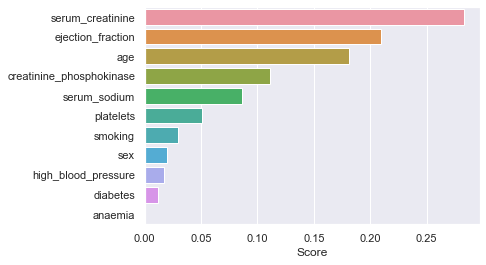

In [739]:
sns.barplot(y=features, x=ranks, orient='h')
plt.xlabel('Score')

In [744]:
best_features = features[:grid_search.best_params_['clf__max_features']]

In [745]:
clf = grid_search.best_estimator_

In [748]:
from sklearn.model_selection import cross_val_predict

In [752]:
X_train_tr.shape

(131, 11)

In [753]:
y_train.shape

(131,)

In [766]:
y_probas = cross_val_predict(clf, X_train_tr, y=y_train, cv=2,
                             method='predict_proba')

In [767]:
y_scores = y_probas[:, 1]

In [768]:
y_scores

array([0.5, 0. , 0. , 0.5, 0.5, 0. , 0.5, 0.5, 0.5, 0. , 0.5, 0.5, 0.5,
       0. , 0.5, 0.5, 0.5, 0.5, 0. , 0.5, 0. , 0. , 0.5, 0.5, 0. , 0. ,
       0.5, 1. , 0.5, 0. , 0.5, 1. , 1. , 0.5, 0.5, 0. , 0. , 0.5, 0. ,
       0.5, 1. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0.5, 0. , 0.5, 0.5, 0. ,
       1. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0.5, 0. , 0.5, 0.5, 0.5, 0. ,
       0. , 0.5, 1. , 1. , 1. , 1. , 0. , 0. , 1. , 0. , 0. , 1. , 0. ,
       0.5, 0. , 1. , 0.5, 1. , 1. , 0.5, 0. , 0.5, 0.5, 1. , 1. , 0.5,
       0.5, 0. , 0.5, 0. , 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. , 0.5, 0.5,
       0.5, 0. , 0.5, 0. , 0. , 0.5, 0. , 0.5, 0.5, 0.5, 0. , 0. , 0. ,
       0. , 0. , 0.5, 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0.5, 0.5, 0.5,
       0. ])

In [774]:
#(clf.predict(X_test) == y_test).sum() / y_test.shape[0]

In [746]:
# clf.predict_proba(X_train_tr[:5])

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [740]:
# Will we get the same x-validation performance using only the best two features?

In [ ]:
X_train_tr_best_features = pd.DataFrame(X_train_tr, columns=df.columns[:-1])[['time', 'serum_creatinine']]

In [ ]:
clf = RandomForestClassifier(**grid_search.best_params_, random_state=42)

clf.fit(X_train_tr_best_features, y_train)

In [ ]:
scores = cross_val_score(clf, X_train_tr_best_features, y_train,
                         scoring="accuracy", cv=5)
print("Scores:", scores)
print("Mean score:", scores.mean())
print("Std dev:", scores.std())

In [ ]:
# strangely nope!
# Let's try using the full set

In [ ]:
scores = cross_val_score(clf, X_train_tr, y_train,
                         scoring="accuracy", cv=5)
print("Scores:", scores)
print("Mean score:", scores.mean())
print("Std dev:", scores.std())

In [ ]:
# Again, after retraining it
clf.fit(X_train_tr, y_train)
scores = cross_val_score(clf, X_train_tr, y_train,
                         scoring="accuracy", cv=5)
print("Scores:", scores)
print("Mean score:", scores.mean())
print("Std dev:", scores.std())

In [ ]:
# Let's use regression to get probabilities


In [ ]:
clf_best = grid_search.best_estimator_

In [ ]:
# Save the best estimator
# First retrain it on a smaller array so the unimportant features are not required in application
clf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
clf.fit(X_train_tr_best_features, y_train)

In [ ]:
import joblib
joblib.dump(clf, "cardio_model.pkl")
# Train the pipeline to require exactly 2 features
X_train_best_features = pd.DataFrame(X_train, columns=df.columns[:-1])[['time', 'serum_creatinine']]
pipeline.fit(X_train_best_features)
joblib.dump(pipeline, 'pipeline.pkl')

In [ ]:
# Test the model on hypothetical new cases
model = joblib.load("cardio_model.pkl")

In [ ]:
X_train_tr_best_features[:3]

In [ ]:
y_train[:3]

In [ ]:
model.predict(X_train_tr_best_features[:3])

In [ ]:
X_train_tr_best_features[:3].shape

# Evalute model performance on the test set

In [ ]:
# TODO: Before I do it, I should implement F1 score, precision/recall, ROC curves and so on in the training.
# Otherwise I might be biased and select a model better performing on the test sample, overtraining it.

# For now, let's just trust "this model is OK" and focus on deployment.

In [ ]:
X_train_tr.shape

In [ ]:
X_train_tr_best_features.shape

In [ ]:
type(X_train_tr_best_features)

In [ ]:
model.predict(np.array([[250, ]]))